In [2]:
import pandas as pd
import numpy as np
import torch
import gdown
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings

# --- CONFIGURATION ---
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. DOWNLOAD DATA
file_ids = {
    'train_split.csv': '1IsyR3Xb_2cfvo457Fh8nE72VTifZb64W',
    'val_split.csv': '1wX4PeKO6fPeLmICA2xmJ3gDUqv_MjE4B',
    'test_split.csv': '1YSyXByVC105ifTZf-FX9IFjlAbZXbdSj',
    'feature_columns.txt': '1PJqBlBZuxocIyHWywBhtaynUn2Pw-y5_'
}
def download_from_drive(ids):
    for filename, fid in ids.items():
        if not os.path.exists(filename):
            url = f'https://drive.google.com/uc?id={fid}'
            gdown.download(url, filename, quiet=False)

download_from_drive(file_ids)

Downloading...
From (original): https://drive.google.com/uc?id=1IsyR3Xb_2cfvo457Fh8nE72VTifZb64W
From (redirected): https://drive.google.com/uc?id=1IsyR3Xb_2cfvo457Fh8nE72VTifZb64W&confirm=t&uuid=9fc76402-e919-489a-a5d2-4192115d97aa
To: /kaggle/working/train_split.csv
100%|██████████| 1.23G/1.23G [00:11<00:00, 110MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1wX4PeKO6fPeLmICA2xmJ3gDUqv_MjE4B
From (redirected): https://drive.google.com/uc?id=1wX4PeKO6fPeLmICA2xmJ3gDUqv_MjE4B&confirm=t&uuid=c3917aed-af69-4957-89ef-423632ed58dc
To: /kaggle/working/val_split.csv
100%|██████████| 161M/161M [00:01<00:00, 112MB/s]  
Downloading...
From (original): https://drive.google.com/uc?id=1YSyXByVC105ifTZf-FX9IFjlAbZXbdSj
From (redirected): https://drive.google.com/uc?id=1YSyXByVC105ifTZf-FX9IFjlAbZXbdSj&confirm=t&uuid=73a44243-5cd5-4676-a073-22cfb11a8098
To: /kaggle/working/test_split.csv
100%|██████████| 161M/161M [00:01<00:00, 84.0MB/s] 
Downloading...
From: https://drive.goog

In [3]:
# 2. DATA LOADING & PREPARATION
# Load full data and sort by date to ensure temporal integrity
df_train = pd.read_csv('train_split.csv')
df_val = pd.read_csv('val_split.csv')
df = pd.concat([df_train, df_val], ignore_index=True)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date') 

with open('feature_columns.txt', 'r') as f:
    features = [line.strip() for line in f.readlines()]

In [4]:
# 3. SCRATCH LINEAR REGRESSION (CUDA)
class LinearRegressionScratch:
    def fit(self, X, y):
        # Adding bias term
        ones = torch.ones((X.shape[0], 1), device=device)
        X_b = torch.cat((ones, X), dim=1)
        # Normal Equation using Pseudo-inverse for numerical stability
        self.weights = torch.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
        
    def predict(self, X):
        ones = torch.ones((X.shape[0], 1), device=device)
        X_b = torch.cat((ones, X), dim=1)
        # Clamp at 0 because sales cannot be negative
        return torch.clamp(X_b @ self.weights, min=0)

# 4. SCRATCH GRADIENT BOOSTED REGRESSOR (CUDA)
class GBDTScratch:
    def __init__(self, n_estimators=10, max_depth=3, lr=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.lr = lr
        self.trees = []

    def fit(self, X, y):
        # Initial prediction (mean of target)
        self.base_pred = torch.mean(y)
        current_preds = torch.full_like(y, self.base_pred)

        for i in range(self.n_estimators):
            # Gradient Boosting: Predict the residuals (errors)
            residuals = y - current_preds
            
            # Build tree on residuals
            tree = self._build_tree(X, residuals, depth=0)
            self.trees.append(tree)
            
            # Update overall predictions with learning rate
            current_preds += self.lr * self._predict_tree(X, tree)
            
            # Requirement: Report RMSE at each boosting stage
           
            rmse = torch.sqrt(torch.mean((y - current_preds)**2))
            print(f"  > Boosting Round {i}, Residual RMSE: {rmse.item():.2f}")

    def _build_tree(self, X, res, depth):
        if depth >= self.max_depth or len(res) < 10:
            return torch.mean(res)

        n_features = X.shape[1]
        best_gain = -1
        split_idx, split_val = 0, 0

        # Optimization: Median-split on sampled features for speed
        for f_idx in range(n_features):
            feat_vals = X[:, f_idx]
            threshold = torch.median(feat_vals)
            
            left_mask = feat_vals <= threshold
            right_mask = ~left_mask
            
            if left_mask.sum() == 0 or right_mask.sum() == 0: continue
            
            # Variance Reduction Gain
            gain = torch.var(res) - (left_mask.sum()*torch.var(res[left_mask]) + 
                                     right_mask.sum()*torch.var(res[right_mask])) / len(res)
            
            if gain > best_gain:
                best_gain, split_idx, split_val = gain, f_idx, threshold

        left_mask = X[:, split_idx] <= split_val
        return {
            'split_idx': split_idx,
            'split_val': split_val,
            'left': self._build_tree(X[left_mask], res[left_mask], depth+1),
            'right': self._build_tree(X[~left_mask], res[~left_mask], depth+1)
        }

    def _predict_tree(self, X, tree):
        if not isinstance(tree, dict):
            return torch.full((X.shape[0],), tree, device=device)
        
        preds = torch.zeros(X.shape[0], device=device)
        left_mask = X[:, tree['split_idx']] <= tree['split_val']
        
        preds[left_mask] = self._predict_tree(X[left_mask], tree['left'])
        preds[~left_mask] = self._predict_tree(X[~left_mask], tree['right'])
        return preds

    def predict(self, X):
        y_pred = torch.full((X.shape[0],), self.base_pred, device=device)
        for tree in self.trees:
            y_pred += self.lr * self._predict_tree(X, tree)
        return torch.clamp(y_pred, min=0)

# 5. EVALUATION: STORE-AWARE TEMPORAL CROSS-VALIDATION
def get_rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2)).item()


In [4]:
for column in df[features].columns:
    if df[column].dtype == 'object':
        print(f"Object Column Found: {column}")
        # Show a few unique values to see what the data looks like
        print(f"Sample values: {train_df[column].unique()[:5]}\n")

In [5]:
tscv = TimeSeriesSplit(n_splits=5)
fold_results_lr = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):
    print(f"\n--- FOLD {fold + 1} / 5 ---")
    
    # Split data based on time-indices
    train_fold = df.iloc[train_idx]
    val_fold = df.iloc[val_idx]
    # 1. Force all columns to numeric and cast the final array to float32
    X_train_numeric = train_fold[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
    X_val_numeric = val_fold[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

    # 2. Now convert the pure float32 array to a Tensor
    X_train = torch.tensor(X_train_numeric, device=device)
    y_train = torch.tensor(train_fold['Sales'].values.astype(np.float32), device=device)
    
    X_val = torch.tensor(X_val_numeric, device=device)
    y_val = torch.tensor(val_fold['Sales'].values.astype(np.float32), device=device)

    # Train Scratch Linear Regression
    lr_model = LinearRegressionScratch()
    lr_model.fit(X_train, y_train)
    lr_rmse = get_rmse(y_val, lr_model.predict(X_val))
    fold_results_lr.append(lr_rmse)
    
print(f"Average Linear Regression RMSE: {np.mean(fold_results_lr):.2f}")


--- FOLD 1 / 5 ---

--- FOLD 2 / 5 ---

--- FOLD 3 / 5 ---

--- FOLD 4 / 5 ---

--- FOLD 5 / 5 ---
Average Linear Regression RMSE: 4106.09


In [6]:
import itertools

# 1. Define the Hyperparameter Grid
param_grid = {
    'max_depth': [3, 4, 5, 10],
    'lr': [0.05, 0.1],
    'n_estimators':[5, 10]
}

# Generate all combinations
keys, values = zip(*param_grid.items())
permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_overall_rmse = float('inf')
best_config = None

print(f"Starting Grid Search over {len(permutations)} combinations...")

# --- NEW OUTER LOOP FOR GRID SEARCH ---
for params in permutations:
    print(f"\n" + "#"*60)
    print(f"TESTING CONFIGURATION: {params}")
    print("#"*60)

    # Defining the Cross-Validation strategy
    # This ensures we test on multiple future windows of the stores
    tscv = TimeSeriesSplit(n_splits=5)
    fold_results_gbdt = []

    print("Starting Store-Aware Temporal Cross-Validation...")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):
        print(f"\n--- FOLD {fold + 1} / 5 ---")
        
        # Split data based on time-indices
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]
        
        # 1. Force all columns to numeric and cast the final array to float32
        X_train_numeric = train_fold[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
        X_val_numeric = val_fold[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

        # 2. Now convert the pure float32 array to a Tensor
        X_train = torch.tensor(X_train_numeric, device=device)
        y_train = torch.tensor(train_fold['Sales'].values.astype(np.float32), device=device)
        
        X_val = torch.tensor(X_val_numeric, device=device)
        y_val = torch.tensor(val_fold['Sales'].values.astype(np.float32), device=device)

        # Train Custom GBDT (Using parameters from Grid Search)
        gbdt_model = GBDTScratch(n_estimators=params["n_estimators"], max_depth=params['max_depth'], lr=params['lr'])
        gbdt_model.fit(X_train, y_train)
        gbdt_rmse = get_rmse(y_val, gbdt_model.predict(X_val))
        fold_results_gbdt.append(gbdt_rmse)

        print(f"Fold Results -> LR RMSE: {lr_rmse:.2f} | GBDT RMSE: {gbdt_rmse:.2f}")

    # Calculate Average for this config
    avg_gbdt_rmse = np.mean(fold_results_gbdt)
    
    # Track the best configuration
    if avg_gbdt_rmse < best_overall_rmse:
        best_overall_rmse = avg_gbdt_rmse
        best_config = params

    # 6. SUMMARY FOR CURRENT CONFIGURATION
    print("\n" + "="*40)
    print(f"SUMMARY FOR CONFIG: {params}")
    print("="*40)
    print(f"Average Custom GBDT RMSE: {avg_gbdt_rmse:.2f}")
    print("="*40)

# FINAL GLOBAL RESULT
print("\n\n" + "!"*60)
print(f"GRID SEARCH COMPLETE")
print(f"BEST CONFIGURATION For gdb: {best_config}")
print(f"LOWEST AVERAGE CV RMSE: {best_overall_rmse:.2f}")
print("!"*60)

Starting Grid Search over 16 combinations...

############################################################
TESTING CONFIGURATION: {'max_depth': 3, 'lr': 0.05, 'n_estimators': 5}
############################################################
Starting Store-Aware Temporal Cross-Validation...

--- FOLD 1 / 5 ---
  > Boosting Round 0, Residual RMSE: 3594.27
  > Boosting Round 1, Residual RMSE: 3452.72
  > Boosting Round 2, Residual RMSE: 3319.41
  > Boosting Round 3, Residual RMSE: 3194.00
  > Boosting Round 4, Residual RMSE: 3075.94
Fold Results -> LR RMSE: 4593.55 | GBDT RMSE: 2969.87

--- FOLD 2 / 5 ---
  > Boosting Round 0, Residual RMSE: 3530.79
  > Boosting Round 1, Residual RMSE: 3392.24
  > Boosting Round 2, Residual RMSE: 3261.62
  > Boosting Round 3, Residual RMSE: 3138.68
  > Boosting Round 4, Residual RMSE: 3023.09
Fold Results -> LR RMSE: 4593.55 | GBDT RMSE: 3398.89

--- FOLD 3 / 5 ---
  > Boosting Round 0, Residual RMSE: 3659.28
  > Boosting Round 1, Residual RMSE: 3516.12
  >

# Analysis: #

The best model was the one with the highest depth and highest number of estimators, which is to be expected. Higher depth models can learn more complex features. And with more estimators, each estimator can fix the mistakes of the previous ones, thus making the model more accurate.

# Training the best parameter model using the entire non-test dataset:

In [7]:
#now, we train a model using the best hyperparameters that we found and test it using the test dataset
# 1. Force all columns to numeric and cast the final array to float32
test_df = pd.read_csv("test_split.csv")
X_train_numeric = df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
X_test_numeric = test_df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

# 2. Now convert the pure float32 array to a Tensor
X_train = torch.tensor(X_train_numeric, device=device)
y_train = torch.tensor(df['Sales'].values.astype(np.float32), device=device)

X_test = torch.tensor(X_test_numeric, device=device)
y_test = torch.tensor(test_df['Sales'].values.astype(np.float32), device=device)

# Train Custom GBDT (Using best parameters)
gbdt_model = GBDTScratch(n_estimators=best_config["n_estimators"], max_depth=best_config["max_depth"], lr=best_config["lr"])
gbdt_model.fit(X_train, y_train)
gbdt_rmse = get_rmse(y_test, gbdt_model.predict(X_test))

print(f"final gbdt rmse = {gbdt_rmse}")

  > Boosting Round 0, Residual RMSE: 3480.38
  > Boosting Round 1, Residual RMSE: 3154.15
  > Boosting Round 2, Residual RMSE: 2859.98
  > Boosting Round 3, Residual RMSE: 2597.37
  > Boosting Round 4, Residual RMSE: 2360.59
  > Boosting Round 5, Residual RMSE: 2148.15
  > Boosting Round 6, Residual RMSE: 1957.33
  > Boosting Round 7, Residual RMSE: 1786.41
  > Boosting Round 8, Residual RMSE: 1634.55
  > Boosting Round 9, Residual RMSE: 1498.38
final gbdt rmse = 1549.60595703125


## Analysis:

We see that as we train more estimators, loss decreases. This is because the latter estimators fix the mistakes of the previous ones. We now increase n_estimators to 50 to achieve an even better performance.

In [8]:
#now, we increase the number of estimators to 50
# 1. Force all columns to numeric and cast the final array to float32
test_df = pd.read_csv("test_split.csv")
X_train_numeric = df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
X_test_numeric = test_df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

# 2. Now convert the pure float32 array to a Tensor
X_train = torch.tensor(X_train_numeric, device=device)
y_train = torch.tensor(df['Sales'].values.astype(np.float32), device=device)

X_test = torch.tensor(X_test_numeric, device=device)
y_test = torch.tensor(test_df['Sales'].values.astype(np.float32), device=device)

# Train Custom GBDT
gbdt_model = GBDTScratch(n_estimators=50, max_depth=10, lr=0.1)
gbdt_model.fit(X_train, y_train)
gbdt_rmse = get_rmse(y_test, gbdt_model.predict(X_test))

print(f"final gbdt test rmse = {gbdt_rmse}")

  > Boosting Round 0, Residual RMSE: 3480.38
  > Boosting Round 1, Residual RMSE: 3154.15
  > Boosting Round 2, Residual RMSE: 2859.98
  > Boosting Round 3, Residual RMSE: 2597.37
  > Boosting Round 4, Residual RMSE: 2360.59
  > Boosting Round 5, Residual RMSE: 2148.15
  > Boosting Round 6, Residual RMSE: 1957.33
  > Boosting Round 7, Residual RMSE: 1786.41
  > Boosting Round 8, Residual RMSE: 1634.55
  > Boosting Round 9, Residual RMSE: 1498.38
  > Boosting Round 10, Residual RMSE: 1377.09
  > Boosting Round 11, Residual RMSE: 1268.68
  > Boosting Round 12, Residual RMSE: 1171.19
  > Boosting Round 13, Residual RMSE: 1084.26
  > Boosting Round 14, Residual RMSE: 1008.35
  > Boosting Round 15, Residual RMSE: 940.88
  > Boosting Round 16, Residual RMSE: 880.84
  > Boosting Round 17, Residual RMSE: 827.75
  > Boosting Round 18, Residual RMSE: 780.64
  > Boosting Round 19, Residual RMSE: 739.81
  > Boosting Round 20, Residual RMSE: 704.20
  > Boosting Round 21, Residual RMSE: 673.02
  > B

In [10]:
#training and testing the base line
# 1. Force all columns to numeric and cast the final array to float32
test_df = pd.read_csv("test_split.csv")
X_train_numeric = df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
X_test_numeric = test_df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

# 2. Now convert the pure float32 array to a Tensor
X_train = torch.tensor(X_train_numeric, device=device)
y_train = torch.tensor(df['Sales'].values.astype(np.float32), device=device)

X_test = torch.tensor(X_test_numeric, device=device)
y_test = torch.tensor(test_df['Sales'].values.astype(np.float32), device=device)
# Train Scratch Linear Regression
lr_model = LinearRegressionScratch()
lr_model.fit(X_train, y_train)
lr_rmse = get_rmse(y_test, lr_model.predict(X_test))
print(f"final base line (regression) test rmse = {lr_rmse}")

final base line (regression) test rmse = 4191.68212890625


In [9]:
torch.save(gbdt_model, "gbdt_model.pt")

In [6]:
url = f'https://drive.google.com/uc?id=180CgJhkaLgGi8AeKCkMKMotO86yZxnol'
gdown.download(url, "gbdt_model.pt", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=180CgJhkaLgGi8AeKCkMKMotO86yZxnol
From (redirected): https://drive.google.com/uc?id=180CgJhkaLgGi8AeKCkMKMotO86yZxnol&confirm=t&uuid=7a0c6185-ebea-423e-9431-c38a9f9ee848
To: /kaggle/working/gbdt_model.pt
100%|██████████| 27.7M/27.7M [00:00<00:00, 136MB/s] 


'gbdt_model.pt'

In [15]:
gbdt_model = torch.load(
    "gbdt_model.pt",
    map_location="cpu",
    weights_only=False
)

In [17]:
import torch
import numpy as np

def model_predict(X_np):
    X_tensor = torch.tensor(X_np, dtype=torch.float32)
    preds = gbdt_model.predict(X_tensor)
    return preds.detach().cpu().numpy()

In [13]:
X_np = df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
background = X_np[np.random.choice(len(X_np), 100, replace=False)]
X_sample = X_np[np.random.choice(len(X_np), 300, replace=False)]

In [18]:
import shap

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(X_sample)
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

feature_importance = sorted(
    zip(features, mean_abs_shap),
    key=lambda x: x[1],
    reverse=True
)

  0%|          | 0/300 [00:00<?, ?it/s]

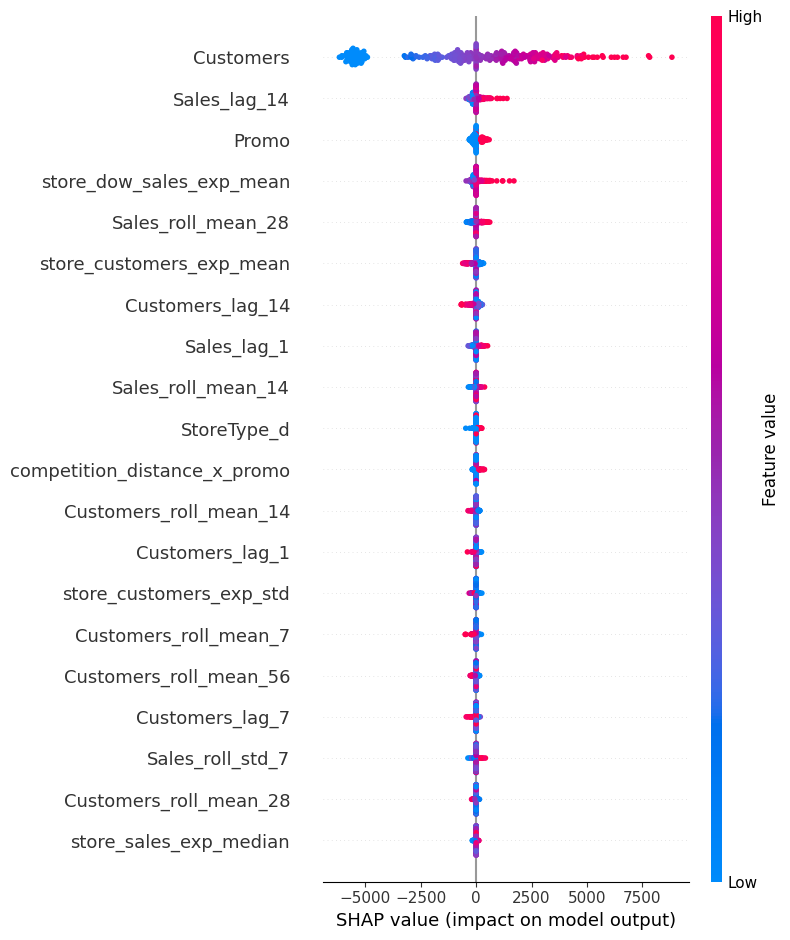

In [19]:
top_k = 20

top_features_idx = np.argsort(mean_abs_shap)[-top_k:]
shap.summary_plot(
    shap_values[:, top_features_idx],
    X_sample[:, top_features_idx],
    feature_names=np.array(features)[top_features_idx]
)